notes: https://github.com/Navkrish04/German-Traffic-Sign-Classification/blob/master/German_Traffic_Data_Final_v1.ipynb

# German Traffic Sign Image Recognition
---

## Import Requiered Libraries

In [2]:
import os
import time as time

import numpy as np
np.random.seed(40)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
%matplotlib inline

from PIL import Image
import time
from datetime import timedelta
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import skimage.morphology as morp
from skimage.filters import rank

import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout # new!
from keras.layers.normalization import BatchNormalization # new!
from keras import regularizers # new! 
from keras.optimizers import SGD
from keras.layers import Flatten, Conv2D, MaxPooling2D # new!
from keras.callbacks import ModelCheckpoint

import cv2

# os.chdir("/Users/Navinkrishnakumar/Documents/DeepLearning")
# os.getcwd()

In [3]:
import pickle
training_file = "traffic_signs_pickled_data/train.p"
testing_file = "traffic_signs_pickled_data/valid.p"
validation_file = "traffic_signs_pickled_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid , y_valid = valid['features'], valid['labels']


In [15]:
print(train)

{'coords': array([[  6,   5,  21,  20],
       [  6,   6,  22,  22],
       [  5,   6,  22,  23],
       ...,
       [ 17,  15, 178, 155],
       [ 17,  15, 183, 160],
       [ 20,  18, 211, 184]], dtype=uint8), 'labels': array([41, 41, 41, ..., 25, 25, 25], dtype=uint8), 'features': array([[[[ 28,  25,  24],
         [ 27,  24,  23],
         [ 27,  24,  22],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  25],
         [ 31,  27,  26]],

        [[ 29,  26,  25],
         [ 27,  25,  23],
         [ 27,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        [[ 28,  26,  26],
         [ 27,  25,  23],
         [ 26,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        ...,

        [[ 27,  24,  23],
         [ 28,  25,  24],
         [ 30,  25,  24],
         ...,
         [ 27,  24,  23],
         [ 28,  24,  22],
         [ 29,  25,  22]],

        [[ 28

## Understand the Dataset shape 

In [9]:

print("Training set -> samples: {}, shape:{}".format(len(X_train), X_train[0].shape))
print("Test set -> samples: {}, shape:{}".format(len(y_test), X_train[0].shape))
print("Validation Set:", len(X_valid))
print("Image Dimensions:", np.shape(X_train[1]))
print("Number of classes:", len(np.unique(y_train)))
n_classes = len(np.unique(y_train))

Training set -> samples: 34799, shape:(32, 32, 3)
Test Set: 4410
Validation Set: 12630
Image Dimensions: (32, 32, 3)
Number of classes: 43


## Descriptive Analysis
---

### Look for class bias

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42]
 [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
   690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
   480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
   210]]


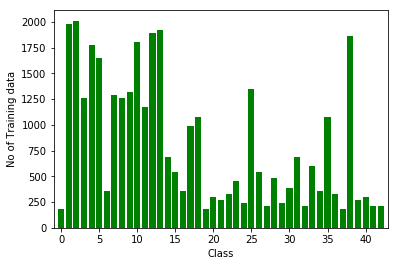

 
We can see that the samples are skewed, there is a definitely bias!


In [36]:
# Checking for class bias 

# get the unique elements 
unique_elements, counts_elements = np.unique(y_train, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

# plot them in the bar graph
pyplot.bar( np.arange( 43 ), counts_elements, align='center',color='green' )
pyplot.xlabel('Class')
pyplot.ylabel('No of Training data')
pyplot.xlim([-1, 43])

# print the graph
pyplot.show()

print(" ")
print("We can see that the samples are skewed, there is a definitely bias!")


### Image Exploration



 
Random Traffic Sign Images from the train set


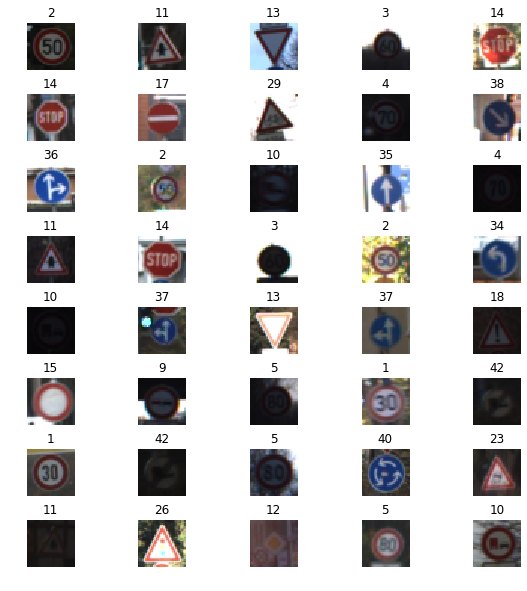

In [24]:
# Show the images

import matplotlib.pyplot as plt
import random
%matplotlib inline


print("\n")
print(" ")
print("Random Traffic Sign Images from the train set")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_train))
#     print("class: ")
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])


# Model Testing without preprocessing(Simple Model)
---

### Neural Network Architecture

In [31]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
# model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))

In [32]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 43)                5547      
Total params: 448,427
Trainable params: 448,427
Non-trainable params: 0
_________________________________________________________________


In [33]:
X_train_baseline = X_train.reshape(len(X_train), 32*32*3).astype('float32')
X_valid_baseline = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
y_train_baseline = keras.utils.to_categorical(y_train, n_classes)
y_valid_baseline = keras.utils.to_categorical(y_valid, n_classes)

model.fit(X_train_baseline, y_train_baseline, batch_size=128, epochs=10, verbose=1, validation_data=(X_valid_baseline, y_valid_baseline))

In [38]:
X_test_baseline = X_test.reshape(len(X_test), 32*32*3).astype('float32')
y_test_baseline = keras.utils.to_categorical(y_test, n_classes)

In [39]:
Pred = model.evaluate(X_test_baseline, y_test_baseline, verbose=0)
print("Dense fully connected network results on the test data - Baseline ")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - Baseline 
 
loss- 15.35
acc- 0.05


#### Observation: 
- This is horrible result for deep learning just using MLP

# Data Preprocessing
---

## Data Augmentation

In [42]:
def data_augment(image):
    rows= image.shape[0]
    cols = image.shape[1]
    
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),10,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
    #img = cv2.warpAffine(img,M_aff,(cols,rows))
    
    # Bilateral filtering
    img = cv2.bilateralFilter(img,9,75,75)
    return img

Note for ^: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html#geometric-transformations

### Normalizing the number of training samples(4000 samples per class)

In [43]:
classes = 43

X_train_final = X_train
y_train_final = y_train
X_aug_1 = []
Y_aug_1 = []

for i in range(0,classes):
    
    class_records = np.where(y_train==i)[0].size
    max_records = 4000
    if class_records != max_records:
        ovr_sample = max_records - class_records
        samples = X_train[np.where(y_train==i)[0]]
        X_aug = []
        Y_aug = [i] * ovr_sample
        
        for x in range(ovr_sample):
            img = samples[x % class_records]
            trans_img = data_augment(img)
            X_aug.append(trans_img)
            
        X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
        y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
        Y_aug_1 = Y_aug_1 + Y_aug
        X_aug_1 = X_aug_1 + X_aug

## Check the class biases after augmentation

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42]
 [4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000]]


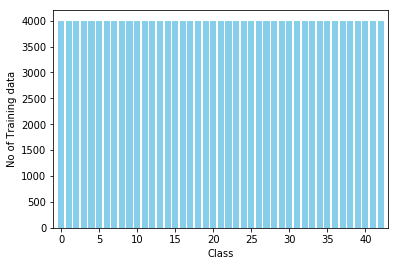

In [47]:
unique_elements, counts_elements = np.unique(y_train_final, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

pyplot.bar( np.arange( 43 ), counts_elements, align='center',color='skyblue')
pyplot.xlabel('Class')
pyplot.ylabel('No of Training data')
pyplot.xlim([-1, 43])

pyplot.show()

As you can see now we have equal number of samples for each classes

## Shape of the dataset after Augmentation
---

In [51]:
print("X train: {}, X train final: {}".format(len(X_train), len(X_train_final)))
print(len(X_train))
print(len(X_train_final))
print(len(y_train))
print(len(y_train_final))

X train: 34799, X train final: 172000
34799
172000
34799
172000


## View images after Augmentation

 
 
Let's view few images to understand our transformations


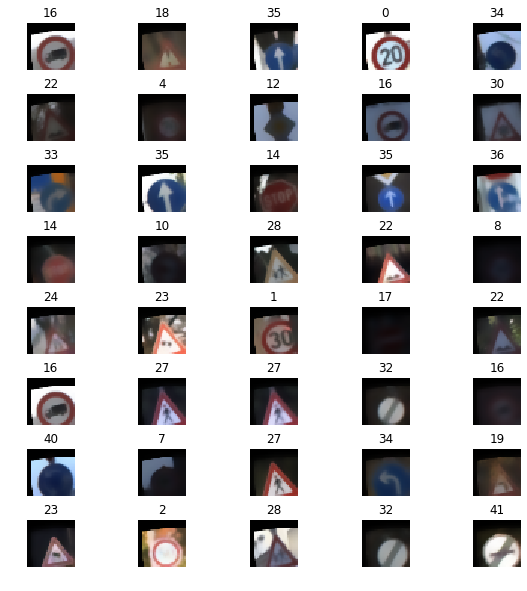

In [52]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
print(" ")
print(" ")
print("Let's view few images to understand our transformations")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_aug_1))
    image = X_aug_1[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(Y_aug_1[index])

## Model testing after data augmentation

In [53]:
X_train_aug = X_train_final.reshape(len(X_train_final), 32*32*3).astype('float32')
X_valid_aug = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
y_train_aug = keras.utils.to_categorical(y_train_final, n_classes)
y_valid_aug = keras.utils.to_categorical(y_valid, n_classes)

In [54]:
filepath="gtsrb_model_with_aug.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#### Model fitting

In [ ]:
model.fit(X_train_aug, y_train_aug, batch_size=128, epochs=100, verbose=1,callbacks=callbacks_list,validation_data=(X_valid_aug, y_valid_aug))